### This is just for storing things I found probably shouldn't be clean but warrant due diligence follow up or possible areas of improvement

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

## Lets load in the metrics data for use

In [3]:
# Path to your SQLite database
db_path = "Subscriptions.db"

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Find all metrics subscription data tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name LIKE 'metrics_subscription_data_%';")
tables = cursor.fetchall()

if not tables:
    print("No metrics_subscription_data tables found in the database.")
else:
    # Extract table names and sort them to find the most recent one
    metrics_tables = [table[0] for table in tables]
    latest_metrics_table = sorted(metrics_tables)[-1]
    
    print(f"Loading data from the most recent metrics table: '{latest_metrics_table}'")
    
    # Query to get all data from the most recent table
    query = f"SELECT * FROM {latest_metrics_table}"
    
    # Load the data into a pandas DataFrame
    df = pd.read_sql_query(query, conn)
    
    # Display basic information about the DataFrame
    print(f"\nLoaded {len(df)} rows and {len(df.columns)} columns")
    print("\nDataFrame shape:", df.shape)
    print("\nColumn names:", list(df.columns))
    print("\nFirst 5 rows:")
    print(df.head())
    
    # Show summary statistics for key metrics columns
    print("\nKey metrics summary:")
    metric_columns = ['payment_periods', 'avg_monthly_payment', 'expansion_ratio', 'has_expanded', 'current_mrr']
    print(df[metric_columns].describe())

# Close the connection
conn.close()

No metrics_subscription_data tables found in the database.


## Now lets take a look at customers who:
- Are active and have current MRR but no total charges
- Have negative total charges

In [4]:


# Assuming df is already loaded with the subscription data and has payment_periods calculated

# 1. Customers with zero charges but long activity (at least 3 months)
zero_charges_df = df[
    (df['total_charges'] == 0) & 
    (df['is_active'] == 1) & 
    (df['converted'] == 1) &
    (df['conversion_date'].notna()) &
    (pd.to_datetime(df['conversion_date']) <= pd.Timestamp('2022-10-16'))
].sort_values('conversion_date')

# 2. Customers with negative charges
negative_charges_df = df[df['total_charges'] < 0].sort_values('total_charges')

# ========================= ANALYSIS OF ZERO CHARGES CUSTOMERS =========================
print("\n=== ANALYSIS OF ZERO CHARGES CUSTOMERS ===")
print(f"Number of customers with zero charges but long activity: {len(zero_charges_df)}")

print("\nProvider distribution:")
provider_counts = zero_charges_df['provider'].value_counts()
print(provider_counts)

print("\nGeography distribution (top 10):")
country_counts = zero_charges_df['personal_person_geo_country'].value_counts().head(10)
print(country_counts)

# Calculate activity months
end_date = datetime(2023, 1, 16)
zero_charges_df['activity_months'] = (end_date - pd.to_datetime(zero_charges_df['conversion_date'])).dt.days / 30

print("\nActivity period statistics (months):")
print(zero_charges_df['activity_months'].describe())

print("\nSample of long-term zero charge customers:")
print(zero_charges_df.sort_values('activity_months', ascending=False).head(10)[
    ['oid', 'provider', 'conversion_date', 'current_mrr', 'is_active', 'activity_months', 'payment_periods']
])



NameError: name 'df' is not defined

In [ ]:

# Calculate potential missed revenue
zero_charges_df['potential_missed_revenue'] = zero_charges_df['current_mrr'] * zero_charges_df['payment_periods']
total_missed_revenue = zero_charges_df['potential_missed_revenue'].sum()

print(f"\nPotential Missed Revenue Analysis:")
print(f"Total potential missed revenue: ${total_missed_revenue:.2f}")
print(f"Average missed revenue per customer: ${total_missed_revenue/len(zero_charges_df):.2f}")

# Check how many have non-zero current MRR
non_zero_mrr_count = len(zero_charges_df[zero_charges_df['current_mrr'] > 0])
print(f"Number of zero-charge customers with non-zero current MRR: {non_zero_mrr_count} ({non_zero_mrr_count/len(zero_charges_df)*100:.2f}%)")

# Potential revenue from just customers with non-zero current MRR
if non_zero_mrr_count > 0:
    non_zero_mrr_df = zero_charges_df[zero_charges_df['current_mrr'] > 0]
    non_zero_missed_revenue = non_zero_mrr_df['potential_missed_revenue'].sum()
    print(f"Potential missed revenue from just customers with non-zero current MRR: ${non_zero_missed_revenue:.2f}")

print("\nSample of long-term zero charge customers:")
print(zero_charges_df.sort_values('potential_missed_revenue', ascending=False).head(10)[
    ['oid', 'provider', 'conversion_date', 'current_mrr', 'is_active', 'payment_periods', 'potential_missed_revenue']
])



Potential Missed Revenue Analysis:
Total potential missed revenue: $17686.57
Average missed revenue per customer: $38.87
Number of zero-charge customers with non-zero current MRR: 455 (100.00%)
Potential missed revenue from just customers with non-zero current MRR: $17686.57

Sample of long-term zero charge customers:
                   oid provider      conversion_date  current_mrr  is_active  \
32829  504582242443575    apple  2022-01-23 00:00:00         5.67          1   
27546  448627612340651    apple  2022-01-13 00:00:00         5.00          1   
15602  161634843615541    apple  2022-01-15 00:00:00         5.00          1   
26926  784423327131691    apple  2022-01-03 00:00:00         5.00          1   
36588  623539211089405    apple  2022-02-06 00:00:00         5.41          1   
40471  700459018227684    apple  2022-02-19 00:00:00         5.82          1   
35695  658474539831054    apple  2022-02-03 00:00:00         5.22          1   
40724  203638495826292    apple  2022-0

In [ ]:

# ========================= ANALYSIS OF NEGATIVE CHARGES CUSTOMERS =========================
print("\n=== ANALYSIS OF NEGATIVE CHARGES CUSTOMERS ===")
print(f"Number of customers with negative charges: {len(negative_charges_df)}")

print("\nProvider distribution:")
neg_provider_counts = negative_charges_df['provider'].value_counts()
print(neg_provider_counts)

print("\nSum of negative charges:")
total_negative = negative_charges_df['total_charges'].sum()
print(f"${total_negative:.2f}")

print("\nDistribution of negative charges:")
print(negative_charges_df['total_charges'].describe())

print("\nCancellation status:")
cancel_status = negative_charges_df['is_canceled'].value_counts()
print(cancel_status)
print(f"Percentage cancelled: {cancel_status.get(1, 0) / len(negative_charges_df) * 100:.2f}%")

print("\nGeography distribution (top 10):")
neg_country_counts = negative_charges_df['personal_person_geo_country'].value_counts().head(10)
print(neg_country_counts)

print("\nSample of customers with most negative charges:")
print(negative_charges_df.sort_values('total_charges').head(10)[
    ['oid', 'provider', 'total_charges', 'conversion_date', 'cancellation_date', 'current_mrr', 'is_canceled', 'payment_periods']
])



=== ANALYSIS OF NEGATIVE CHARGES CUSTOMERS ===
Number of customers with negative charges: 391

Provider distribution:
provider
apple     383
google      8
Name: count, dtype: int64

Sum of negative charges:
$-419.62

Distribution of negative charges:
count    391.000000
mean      -1.073197
std        7.369842
min     -119.980000
25%       -0.460000
50%       -0.210000
75%       -0.080000
max       -0.010000
Name: total_charges, dtype: float64

Cancellation status:
is_canceled
0    247
1    144
Name: count, dtype: int64
Percentage cancelled: 36.83%

Geography distribution (top 10):
personal_person_geo_country
United Kingdom of Great Britain and Northern Ireland    67
Germany                                                 50
Canada                                                  30
France                                                  23
Australia                                               21
China                                                   21
Italy                        

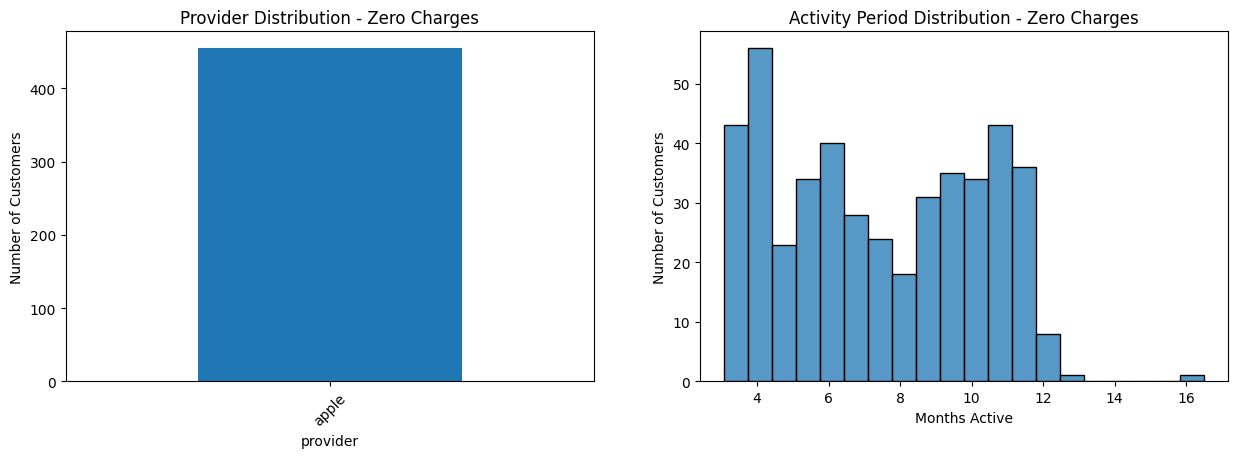

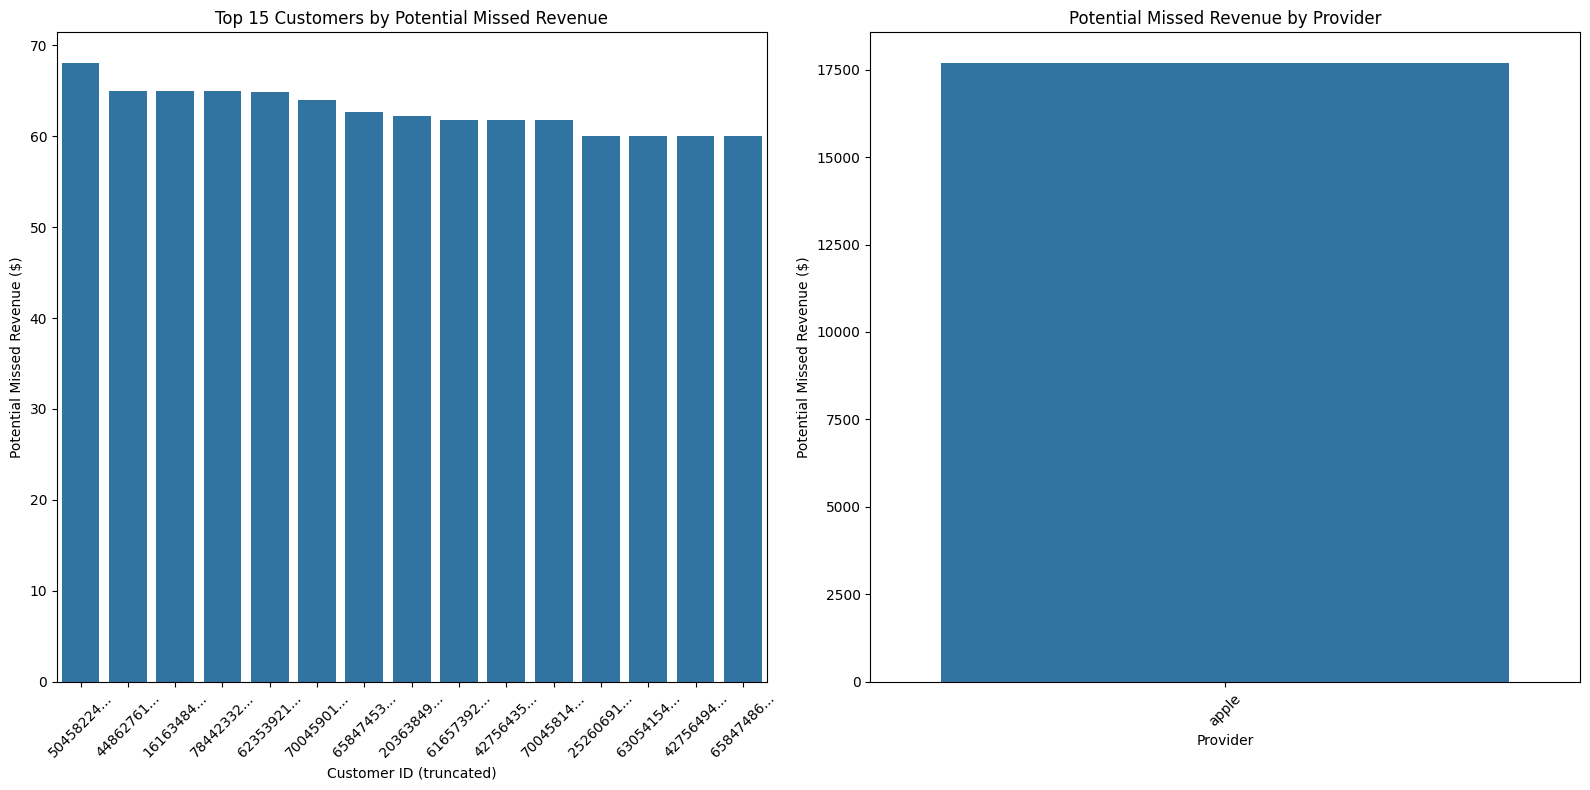

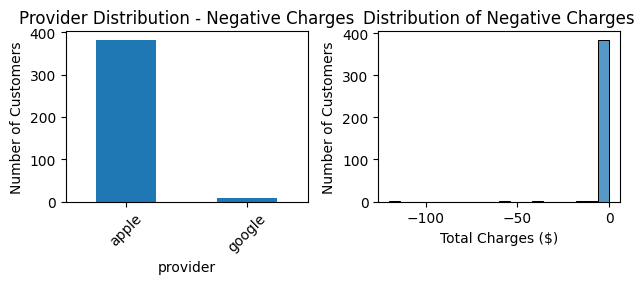

In [ ]:

# ========================= VISUALIZATIONS =========================

# Setup for plotting
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)

# 1. Provider distribution for zero charges
provider_counts.plot(kind='bar')
plt.title('Provider Distribution - Zero Charges')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)

# 2. Activity months histogram for zero charges
plt.subplot(2, 2, 2)
sns.histplot(zero_charges_df['activity_months'], bins=20)
plt.title('Activity Period Distribution - Zero Charges')
plt.xlabel('Months Active')
plt.ylabel('Number of Customers')

# Add a new figure for missed revenue analysis
plt.figure(figsize=(16, 8))

# If there are customers with non-zero MRR
if len(zero_charges_df[zero_charges_df['current_mrr'] > 0]) > 0:
    plt.subplot(1, 2, 1)
    # Get top 15 customers by missed revenue for visualization
    top_missed_revenue = zero_charges_df.sort_values('potential_missed_revenue', ascending=False).head(15)
    
    # Plot missed revenue by customer (top 15)
    sns.barplot(x=top_missed_revenue['oid'].astype(str).str[:8] + '...', 
                y='potential_missed_revenue', data=top_missed_revenue)
    plt.title('Top 15 Customers by Potential Missed Revenue')
    plt.ylabel('Potential Missed Revenue ($)')
    plt.xlabel('Customer ID (truncated)')
    plt.xticks(rotation=45)
    
    plt.subplot(1, 2, 2)
    # Plot missed revenue by provider
    missed_by_provider = zero_charges_df.groupby('provider')['potential_missed_revenue'].sum().sort_values(ascending=False)
    sns.barplot(x=missed_by_provider.index, y=missed_by_provider.values)
    plt.title('Potential Missed Revenue by Provider')
    plt.ylabel('Potential Missed Revenue ($)')
    plt.xlabel('Provider')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    #plt.savefig('missed_revenue_analysis.png')
    plt.show()
    plt.close()

# 3. Provider distribution for negative charges
plt.subplot(2, 2, 3)
neg_provider_counts.plot(kind='bar')
plt.title('Provider Distribution - Negative Charges')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)

# 4. Negative charges distribution
plt.subplot(2, 2, 4)
sns.histplot(negative_charges_df['total_charges'], bins=20)
plt.title('Distribution of Negative Charges')
plt.xlabel('Total Charges ($)')
plt.ylabel('Number of Customers')

plt.tight_layout()
#plt.savefig('zero_negative_charges_analysis.png')
plt.show()
plt.close()



### ========================= 
# RECOMMENDATIONS 
### =========================

## For Zero Charges Customers:
- Investigate why these customers have zero charges despite long activity
- Check if these are internal accounts, testing accounts, or special arrangements
- Verify if there is a billing system issue for specific providers
- Consider implementing a review process for accounts with $0 charges after 3+ months

## For Negative Charges Customers:
- Looks like a reasonable refund population but could be worth looking into outliers with high refunds to get ahead of fraud
- Analyze the refund patterns to understand the reasons
- Check if specific providers or countries have higher refund rates
- For large negative amounts, conduct a detailed review of individual cases
- Consider adding a classification system for refund reasons to track patterns

### Lets now look at the places where sign up date is after conversion date which doesnt make sense, probably data quality issue

In [ ]:
print(df[df['signup_date'] > df['conversion_date']].count())
print(df[df['signup_date'] > df['conversion_date']])

oid                            16
provider                       16
total_charges                  16
signup_date                    16
is_canceled                    16
is_active                      16
is_delinquent                  16
conversion_date                16
cancellation_date              16
current_mrr                    16
personal_person_geo_country    16
converted                      16
payment_periods                16
avg_monthly_payment            16
expansion_ratio                16
has_expanded                   16
price_tier                     16
conversion_speed               16
conversion_speed_category       0
conversion_cohort              16
signup_cohort                  16
dtype: int64
                             oid provider  total_charges          signup_date  \
112561  GPA.3319-9266-5306-16298   google           8.38  2022-11-19 00:00:00   
114687  GPA.3371-4654-4661-23422   google          64.83  2022-11-23 00:00:00   
118308  GPA.3382-4129-7346-601

In [ ]:
df['oid'].nunique()

134602

In [ ]:
# Find all rows where 'oid' appears more than once
duplicate_rows = df[df['oid'].duplicated(keep=False)]

# Display these duplicate rows
print(duplicate_rows.count())
print("\nRows with duplicate 'oid' values:")
print(duplicate_rows)


# Alternatively, to sort them by 'oid' for easier viewing:
print(duplicate_rows.sort_values('oid'))

oid                            14
provider                       14
total_charges                  14
signup_date                    14
is_canceled                    14
is_active                      14
is_delinquent                  14
conversion_date                12
cancellation_date               3
current_mrr                    14
personal_person_geo_country    14
converted                      14
payment_periods                12
avg_monthly_payment            12
expansion_ratio                12
has_expanded                   14
price_tier                     12
conversion_speed               12
conversion_speed_category       6
conversion_cohort              12
signup_cohort                  14
dtype: int64

Rows with duplicate 'oid' values:
             oid provider  total_charges          signup_date  is_canceled  \
59545   1.68E+15    apple          71.91  2022-05-04 00:00:00            0   
59645  1.736E+15    apple           0.00  2022-05-04 00:00:00            0   
5967

### Should investigate these 14 duplicate oid

- If they are test accounts we should remove from the data
- If not this presents a key issue to fix to protext integrity of data feeds as this is most likely the primary key for customer

In [ ]:
df[(df['converted'] == 1) & (df['is_active'] == 0) & (df['is_canceled'] == 0)]
# df2 = df[(df['converted'] == 1) & (df['is_active'] == 0) & (df['is_canceled'] == 0)]
# df2[df['current_mrr'] != 0]

,oid,provider,total_charges,signup_date,is_canceled,is_active,is_delinquent,conversion_date,cancellation_date,current_mrr,...,converted,payment_periods,avg_monthly_payment,expansion_ratio,has_expanded,price_tier,conversion_speed,conversion_speed_category,conversion_cohort,signup_cohort
166,210537904100064,apple,39.90,2021-04-21 00:00:00,0,0,0,2021-04-21 00:00:00,None,0.0,...,1,21.0,1.900000,0.0,0,$0-$2.50,0.0,None,2021-04,2021-04
785,266611180142141,apple,49.36,2021-04-30 00:00:00,0,0,0,2021-04-30 00:00:00,None,0.0,...,1,21.0,2.350476,0.0,0,$0-$2.50,0.0,None,2021-04,2021-04
921,266602956049369,apple,39.92,2021-05-03 00:00:00,0,0,0,2021-05-03 00:00:00,None,0.0,...,1,21.0,1.900952,0.0,0,$0-$2.50,0.0,None,2021-05,2021-05
1459,700447553214467,apple,10.94,2021-05-11 00:00:00,0,0,0,2021-05-11 00:00:00,None,0.0,...,1,21.0,0.520952,0.0,0,$0-$2.50,0.0,None,2021-05,2021-05
1651,154531454937862,apple,55.81,2021-05-13 00:00:00,0,0,0,2021-05-13 00:00:00,None,0.0,...,1,21.0,2.657619,0.0,0,$2.50-$5,0.0,None,2021-05,2021-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129964,609588630404238,apple,8.52,2023-01-04 00:00:00,0,0,0,2023-01-04 00:00:00,None,0.0,...,1,1.0,8.520000,0.0,0,$7.50-$10,0.0,None,2023-01,2023-01
130204,196592513836259,apple,7.99,2023-01-04 00:00:00,0,0,0,2023-01-09 00:00:00,None,0.0,...,1,1.0,7.990000,0.0,0,$7.50-$10,5.0,1-7 days,2023-01,2023-01
130363,532575754467906,apple,8.40,2023-01-05 00:00:00,0,0,0,2023-01-07 00:00:00,None,0.0,...,1,1.0,8.400000,0.0,0,$7.50-$10,2.0,1-7 days,2023-01,2023-01
131332,539487128910431,apple,7.99,2023-01-07 00:00:00,0,0,0,2023-01-11 00:00:00,None,0.0,...,1,1.0,7.990000,0.0,0,$7.50-$10,4.0,1-7 days,2023-01,2023-01


### Population of customers who have converted but are no longer bringing in revenue 
- Investigate if these are all purely test accounts but otherwise this is a something that needs to be looked at for data integrity

In [ ]:
# Filter for customers with expansion ratio above 5
high_expansion_customers = df[df['expansion_ratio'] > 5]
high_expansion_customers

,oid,provider,total_charges,signup_date,is_canceled,is_active,is_delinquent,conversion_date,cancellation_date,current_mrr,...,converted,payment_periods,avg_monthly_payment,expansion_ratio,has_expanded,price_tier,conversion_speed,conversion_speed_category,conversion_cohort,signup_cohort
1473,427551670491822,apple,11.45,2021-05-11 00:00:00,0,1,0,2021-05-18 00:00:00,None,3.48,...,1,20.0,0.572500,6.078603,1,$0-$2.50,7.0,1-7 days,2021-05,2021-05
4050,266617950485623,apple,23.97,2021-07-14 00:00:00,0,1,0,2021-07-21 00:00:00,None,8.16,...,1,18.0,1.331667,6.127660,1,$0-$2.50,7.0,1-7 days,2021-07,2021-07
4952,623531991967446,apple,1.87,2021-08-05 00:00:00,0,1,0,2021-08-05 00:00:00,None,5.78,...,1,18.0,0.103889,55.636364,1,$0-$2.50,0.0,None,2021-08,2021-08
6627,161630683176419,apple,0.00,2021-09-01 00:00:00,0,1,0,2021-09-08 00:00:00,None,3.33,...,1,17.0,0.000000,inf,1,Negative,7.0,1-7 days,2021-09,2021-09
8270,161631593962246,apple,0.26,2021-09-21 00:00:00,0,1,0,2021-09-28 00:00:00,None,5.06,...,1,16.0,0.016250,311.384615,1,$0-$2.50,7.0,1-7 days,2021-09,2021-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121393,609587307403650,apple,0.00,2022-12-07 00:00:00,0,1,0,2022-12-14 00:00:00,None,5.00,...,1,2.0,0.000000,inf,1,Negative,7.0,1-7 days,2022-12,2022-12
123584,GPA.3319-1599-5149-77288,google,0.00,2022-12-14 00:00:00,0,1,0,2022-12-14 00:00:00,None,9.89,...,1,2.0,0.000000,inf,1,Negative,0.0,None,2022-12,2022-12
127519,259685489442353,apple,0.00,2022-12-27 00:00:00,0,1,0,2023-01-04 00:00:00,None,5.04,...,1,1.0,0.000000,inf,1,Negative,8.0,8-14 days,2023-01,2022-12
128745,266646981945283,apple,0.00,2022-12-31 00:00:00,0,1,0,2023-01-08 00:00:00,None,5.00,...,1,1.0,0.000000,inf,1,Negative,8.0,8-14 days,2023-01,2022-12


### Population of customers whose current MRR is much higher than their avg payment, could be trial period customers or something else


Current MRR as Percentage of Average Monthly Payment by Signup Cohort:
   signup_cohort  mrr_to_monthly_percentage  current_mrr  avg_monthly_payment  \
0        2021-04                      93.98         4.14                 4.40   
1        2021-05                      96.35         4.31                 4.47   
2        2021-06                      76.90         4.24                 5.51   
3        2021-07                      83.71         3.85                 4.60   
4        2021-08                      80.89         4.02                 4.97   
5        2021-09                      77.67         4.29                 5.53   
6        2021-10                      77.35         6.04                 7.81   
7        2021-11                      71.18         5.62                 7.90   
8        2021-12                      71.29         5.40                 7.57   
9        2022-01                      96.61         5.29                 5.47   
10       2022-02                     1

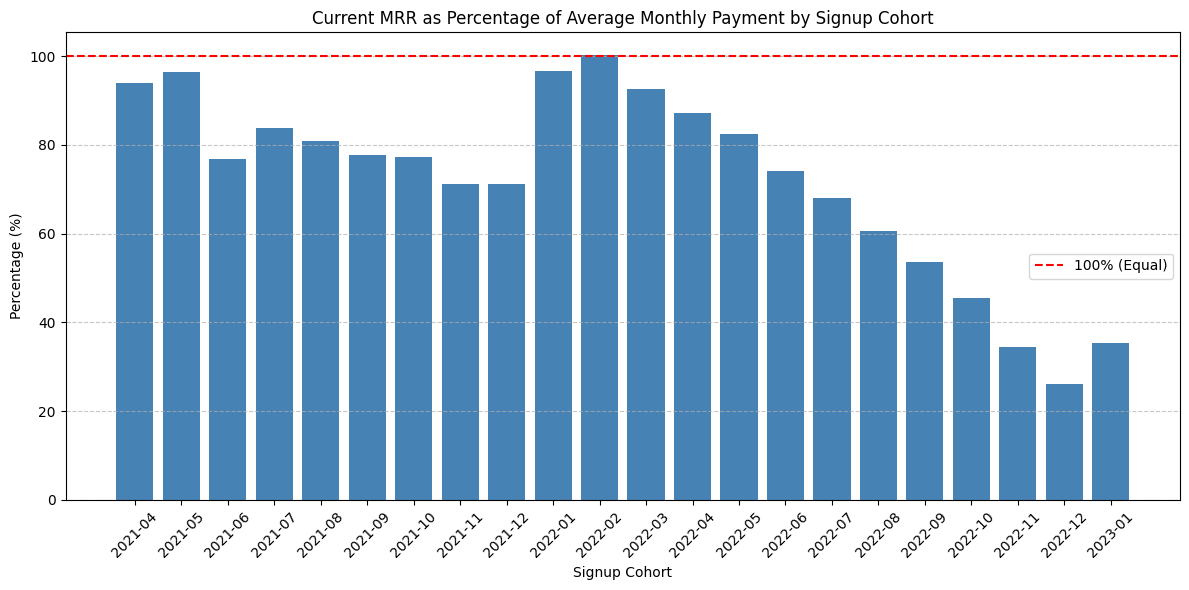

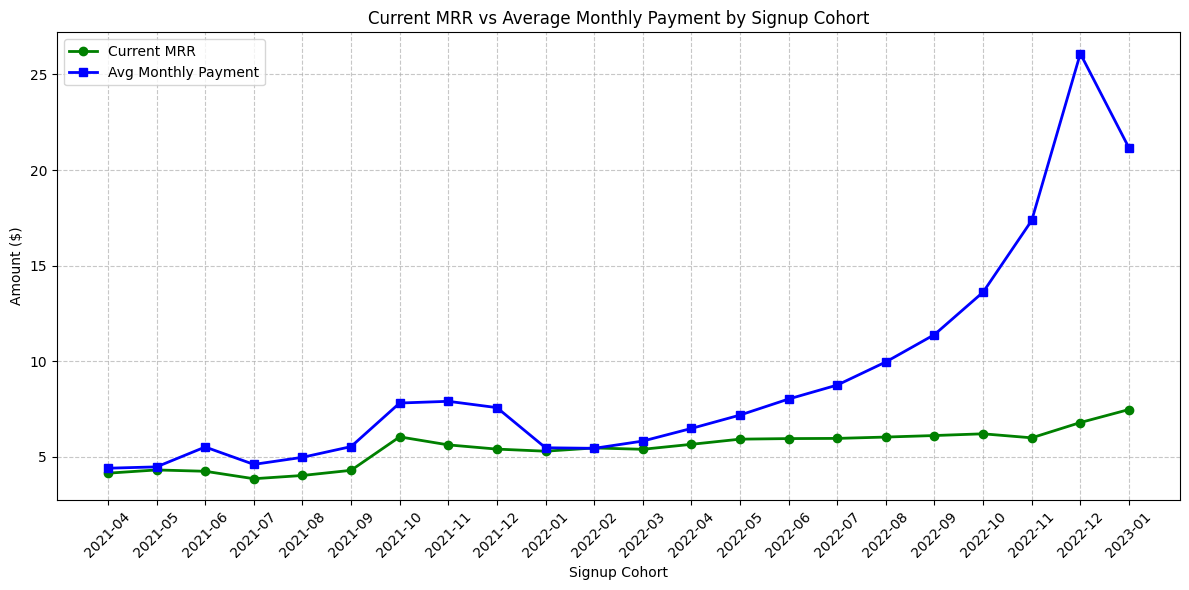

In [ ]:
# Filter for relevant customers
active_converted = df[(df['converted'] == 1) & (df['is_active'] == 1)]

# Group by signup cohort
cohort_analysis = active_converted.groupby('signup_cohort').agg({
    'current_mrr': 'mean',
    'avg_monthly_payment': 'mean',
    'oid': 'count',
    'payment_periods': 'mean'
}).reset_index()

# Calculate current MRR as percentage of avg monthly payment
cohort_analysis['mrr_to_monthly_percentage'] = (cohort_analysis['current_mrr'] / cohort_analysis['avg_monthly_payment']) * 100

# Sort by signup cohort
cohort_analysis = cohort_analysis.sort_values('signup_cohort')

# Format for better readability
cohort_analysis['mrr_to_monthly_percentage'] = cohort_analysis['mrr_to_monthly_percentage'].round(2)
cohort_analysis['current_mrr'] = cohort_analysis['current_mrr'].round(2)
cohort_analysis['avg_monthly_payment'] = cohort_analysis['avg_monthly_payment'].round(2)
cohort_analysis['payment_periods'] = cohort_analysis['payment_periods'].round(1)

# Display the results
print("Current MRR as Percentage of Average Monthly Payment by Signup Cohort:")
print(cohort_analysis[['signup_cohort', 'mrr_to_monthly_percentage', 'current_mrr', 
                      'avg_monthly_payment', 'payment_periods', 'oid']])

# Create a visualization to see the trend
plt.figure(figsize=(12, 6))
plt.bar(cohort_analysis['signup_cohort'], cohort_analysis['mrr_to_monthly_percentage'], color='steelblue')
plt.axhline(y=100, color='red', linestyle='--', label='100% (Equal)')
plt.title('Current MRR as Percentage of Average Monthly Payment by Signup Cohort')
plt.xlabel('Signup Cohort')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# Also plot both values to see the absolute difference
plt.figure(figsize=(12, 6))
plt.plot(cohort_analysis['signup_cohort'], cohort_analysis['current_mrr'], 'o-', 
         label='Current MRR', linewidth=2, color='green')
plt.plot(cohort_analysis['signup_cohort'], cohort_analysis['avg_monthly_payment'], 's-', 
         label='Avg Monthly Payment', linewidth=2, color='blue')
plt.title('Current MRR vs Average Monthly Payment by Signup Cohort')
plt.xlabel('Signup Cohort')
plt.ylabel('Amount ($)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

### The above is a heavy indication that there are more than just monthly subscriptions - should look to seperate these costs out